In [1]:
!pip install -U datasets huggingface_hub fsspec pandas scikit-learn matplotlib seaborn numpy sentence-transformers

  Using cached fsspec-2025.7.0-py3-none-any.whl.metadata (12 kB)


In [2]:
from datasets import load_dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Load dataset
dataset = load_dataset("sonnh-tech1/cic-ids-2017", "binary")
df = dataset["train"].to_pandas()
print(df)

# Encode label
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])  # BENIGN=0, ATTACK=1

# Keep only numeric features
X = df.select_dtypes(include=['int64', 'float64']).drop(columns=['Label'])
y = df['Label']

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/92.8M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/107M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/108M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/107M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2522362 [00:00<?, ? examples/s]

         DestinationPort  FlowDuration  TotalFwdPackets  TotalBackwardPackets  \
0                  54865             3                2                     0   
1                  55054           109                1                     1   
2                  55055            52                1                     1   
3                  46236            34                1                     1   
4                  54863             3                2                     0   
...                  ...           ...              ...                   ...   
2522357               53         32215                4                     2   
2522358               53           324                2                     2   
2522359            58030            82                2                     1   
2522360               53       1048635                6                     2   
2522361               53         94939                4                     2   

         TotalLengthofFwdPa

In [4]:
# 1️⃣ Random Forest
rf = RandomForestClassifier(
    n_estimators=40,         # Fewer trees
    max_depth=6,             # Shallower trees
    min_samples_leaf=10,     # Fewer splits
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)


In [5]:
# 2️⃣ ANN (MLP)
ann = MLPClassifier(
    hidden_layer_sizes=(32, 16),  # Smaller network
    activation='relu',
    max_iter=30,
    solver='adam',
    random_state=42
)


In [6]:
!pip install xgboost
from xgboost import XGBClassifier

gb = XGBClassifier(
    n_estimators=5,       # Fewer boosting rounds
    max_depth=2,          # Simpler trees
    learning_rate=0.03,   # Smaller updates
    tree_method='gpu_hist',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

In [7]:
# Convert X_scaled into sentence-style text
text_data = pd.DataFrame(X_scaled).astype(str).agg(' '.join, axis=1)

# Sentence Embedding
model_slm = SentenceTransformer('paraphrase-MiniLM-L3-v2')
X_embed = model_slm.encode(text_data.tolist(), show_progress_bar=True)

# SLM split
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_embed, y, test_size=0.2, stratify=y, random_state=42
)

# Lightweight classifier
slm_model = LogisticRegression(max_iter=1000, class_weight='balanced')
slm_model.fit(X_train_s, y_train_s)



modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/78824 [00:00<?, ?it/s]

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [8]:
slm_model = LogisticRegression(
    max_iter=100,
    class_weight='balanced',
    C=0.3               # Add regularization (smaller C = stronger penalty)
)

In [9]:
#✅ STEP 5: Predict and Perform Decision Fusion

# Fit the models
rf.fit(X_train, y_train)
ann.fit(X_train, y_train)
gb.fit(X_train, y_train),
slm_model.fit(X_train_s, y_train_s) # Fit the SLM model

# Predict from all 4 models
rf_pred = rf.predict(X_test)
ann_pred = ann.predict(X_test)
gb_pred = gb.predict(X_test)
slm_pred = slm_model.predict(X_test_s)

# Stack predictions
all_preds = np.vstack([rf_pred, ann_pred, gb_pred, slm_pred])

# Majority voting
from scipy.stats import mode
fusion_pred, _ = mode(all_preds, axis=0)
fusion_pred = fusion_pred.flatten()

✅ Fusion Accuracy: 0.9911
✅ Weighted F1 Score: 0.9907

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    419297
           1       0.99      0.39      0.56       391
           2       1.00      0.99      1.00     25603
           3       0.98      0.96      0.97      2057
           4       1.00      0.93      0.96     34570
           5       0.90      0.93      0.91      1046
           6       0.98      0.94      0.96      1077
           7       1.00      0.99      0.99      1187
           8       1.00      1.00      1.00         2
           9       1.00      0.29      0.44         7
          10       0.96      0.99      0.98     18164
          11       0.98      0.96      0.97       644
          12       1.00      0.09      0.16       294
          13       0.01      0.50      0.02         4
          14       1.00      0.01      0.02       130

    accuracy                           0.99    504473

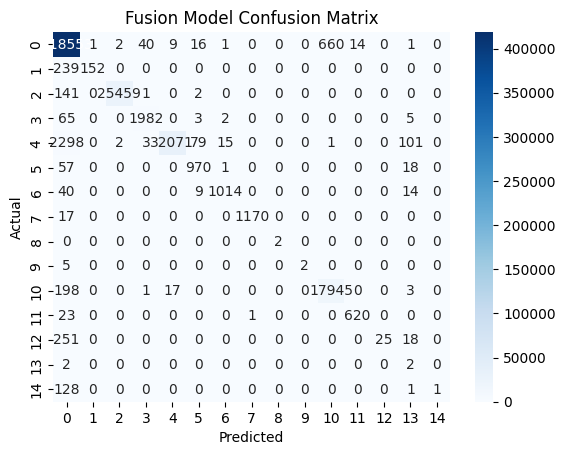

In [10]:
#✅ STEP 6: Evaluate the Fused Model and Plot Confusion Matrix

acc = accuracy_score(y_test, fusion_pred)
f1 = f1_score(y_test, fusion_pred, average='weighted')

print(f"✅ Fusion Accuracy: {acc:.4f}")
print(f"✅ Weighted F1 Score: {f1:.4f}\n")

print("📄 Classification Report:\n", classification_report(y_test, fusion_pred))
print("📊 Confusion Matrix:\n", confusion_matrix(y_test, fusion_pred))

# Plot confusion matrix
conf_mat = confusion_matrix(y_test, fusion_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Fusion Model Confusion Matrix")
plt.show()
